In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate

def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix

modelLoads= ["AB", "BA", "BB", "infer2018"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "RGG"]
soleGraphs= ["ba1", "ba2", "ba3", "er1", "er2", "er3"]
realGraphs= ["contious_Africa", "contious_china", "contious_EU", "contious_usa", "mobility_german", "mobility_us"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
denses= [-3, -4]
nodes= [50, 200, 400]
intenses= [0, 1, 2]

identicalfs= [5e-4, 1e-3, 2e-3, 5e-3, 2e-2, 5e-2, 1e-1]# except 1e-2
identicalfsAdd= [2e-4]


commands1=set()
linuxThread= 4

c:\Users\30678\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Performance on sole graphs new 4*5*4*4=320
count2= 0
for soleGraph in realGraphs:
    for strain in strains:
        count2+=1
        command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {soleGraph}\
        --seed {11} --strains {strain}  --dense {0} --n {100} --intense {-1}"
        commands1.add(command)


In [28]:
#Performance on different models new 4*5*4*4=320
count2= 0
for randomGraph in randomGraphs:
    for seed in seeds:
        for modelL in modelLoads:
            for strain in strains:
                count2+=1
                command= f"python run.py --epoches {150000} --modelLoad {modelL} --weightModel identical --randomGraph {randomGraph}\
                --seed {seed} --strains {strain}  --dense {0} --n {100} --intense {-1}"
                commands1.add(command)


In [ ]:
#Performance on different strains new
for randomGraph in randomGraphs:
    for seed in seeds:
        for strain in strains:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
              --seed {seed} --strains {strain}  --dense {0} --n {100} --intense {-1}"
            commands1.add(command)

In [ ]:
#optimial identical f gross

for randomGraph in randomGraphs:
    for seed in seeds:
        for identicalf in identicalfsAdd:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
              --seed {seed} --strains {4}  --dense {0} --n {100} --intense {-1} --identicalf {identicalf}"
            commands1.add(command)

In [3]:
#Performance on different node number
for randomGraph in randomGraphs:
    for seed in seeds:
        for node in nodes:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
            --seed {seed} --strains 4   --dense {0} --n {node} --intense {-1} --identicalf {0.01}"
            commands1.add(command)

In [4]:
#Performance on different intense
for randomGraph in randomGraphs:
    for seed in seeds:
        for intsense in intenses:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
            --seed {seed} --strains 4   --dense {0} --n 100 --intense {intsense} --identicalf {0.01}"
            commands1.add(command)

In [ ]:
#Performance on different dense
for randomGraph in randomGraphs:
    for seed in seeds:
        for dense in denses:
            command= f"python run.py --epoches {150000} --modelLoad AA --weightModel identical --randomGraph {randomGraph}\
            --seed {seed} --strains 4   --dense {dense} --n 100 --intense -1 --identicalf {0.01}"
            commands1.add(command)

In [3]:
count=0
with open("myCommands.sh", 'w') as file:
    # Write each element on a new line
    for i, string in enumerate(commands1):
        file.write(f"echo \"{string} --CMDprogress_{i}_{len(commands1)-1}\"\n")
        file.write(f"{string} --CMDprogress_{i}_{len(commands1)-1} &\n")
        count+=1
        if count%linuxThread==0:
            file.write("wait\n")
    if count%linuxThread !=0:
        file.write("wait\n")

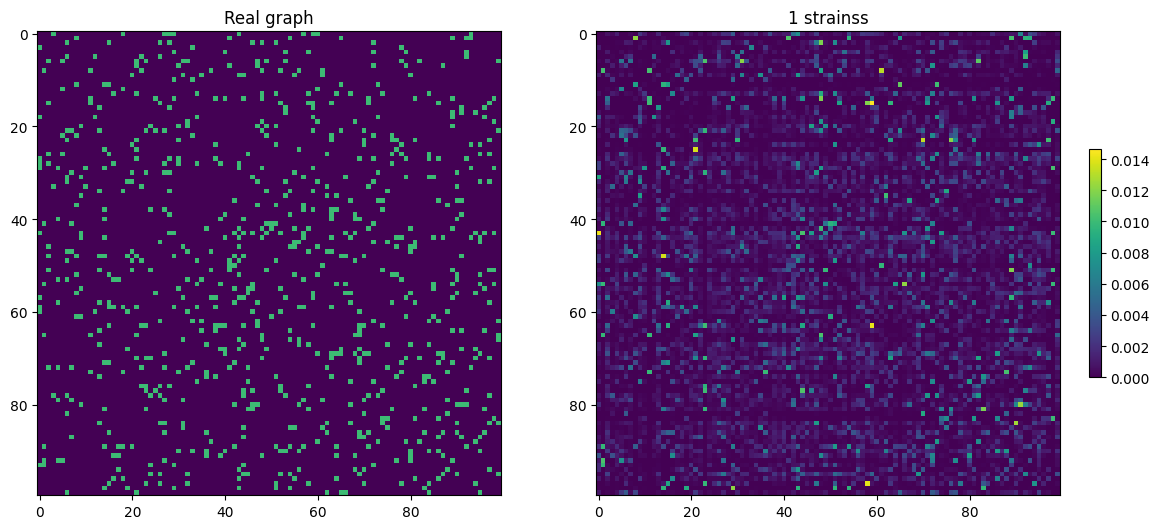

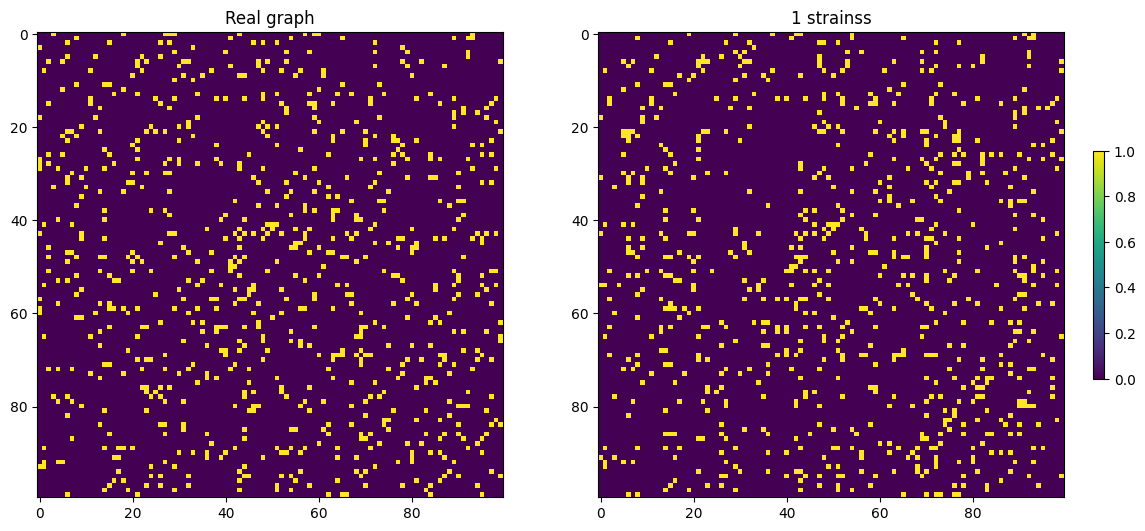

0.03947173


In [96]:
import matplotlib.pyplot as plt
import numpy as np
import modules.plotGraph as plotGraph
import networkx as nx
from matplotlib.colors import Normalize

IMatrixNp= np.eye(50)

maxValue= 0
def load_npz_matrix(fileName, maxValue):
    npzfile = np.load(fileName)
    # Access the arrays in the NPZ file
    Aw = npzfile['A']
    PreA = npzfile['Apre']
    tempMax= np.max(PreA)
    if maxValue<tempMax:
        maxValue=tempMax
    return Aw, PreA, maxValue

#AA_WS_identical_11_4_-1_0_100_10.0_150000

PreAs=[]
Aw= None
randomGraph= "ER"
seed= 12
CosSims= []
for i in range(4):
    fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{i+1}_-1_0_100_{0.01*1000}_150000.npz"
    Aw, PreA, maxValue= load_npz_matrix(fileName, maxValue)
    links= int((np.sum(Aw))/0.01)
    Awsp= continious_to_sparcity(Aw, links)
    CosSim= evaluate.cosine_similarity(torch.tensor(Aw), torch.tensor(PreA))
    CosSims.append(round(CosSim.item(), 2))
    PreAs.append(PreA)

PreAsp= [continious_to_sparcity(i, links) for i in PreAs]
campThis= "viridis"

plotGraph.plot_adjacenty(Aw, [PreAs[-1]])
plotGraph.plot_adjacenty(Awsp, [PreAsp[-1]])
print(maxValue)

800


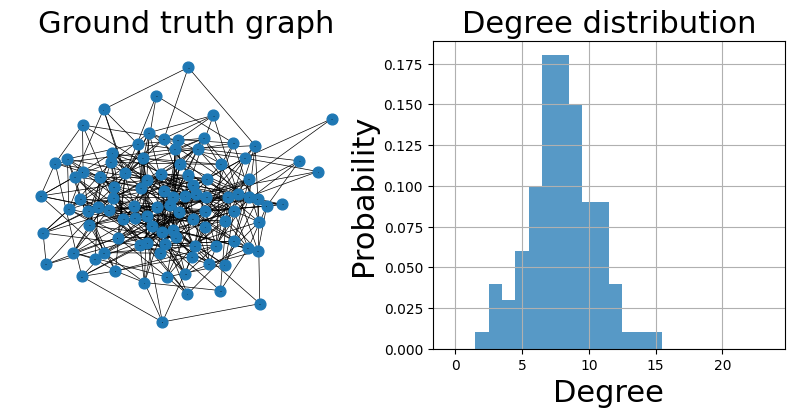

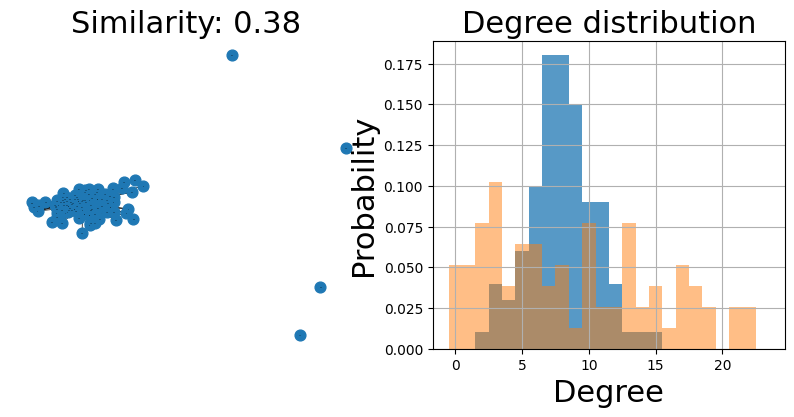

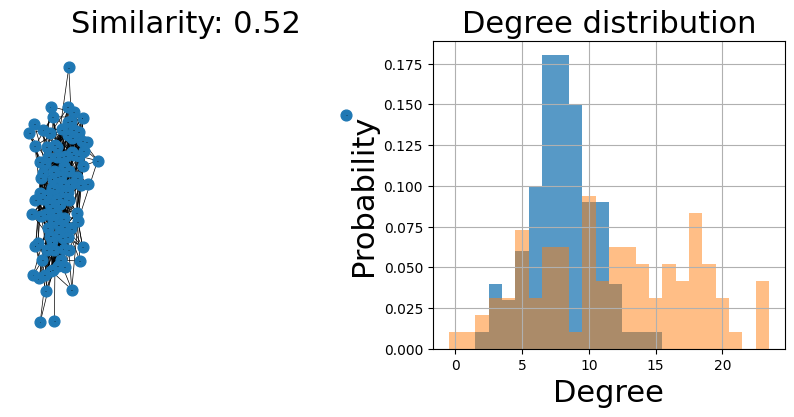

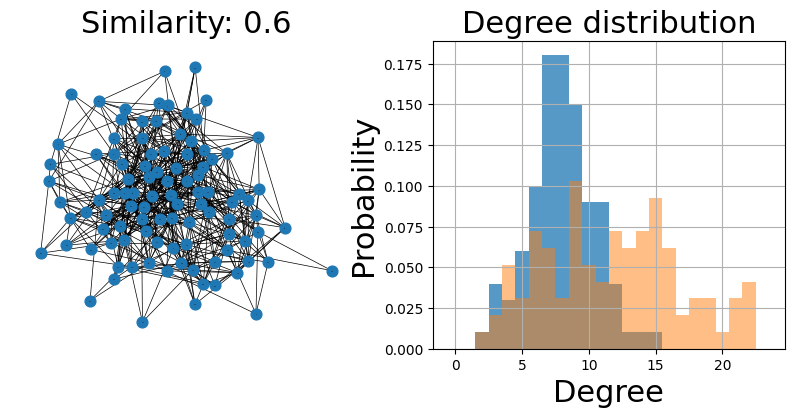

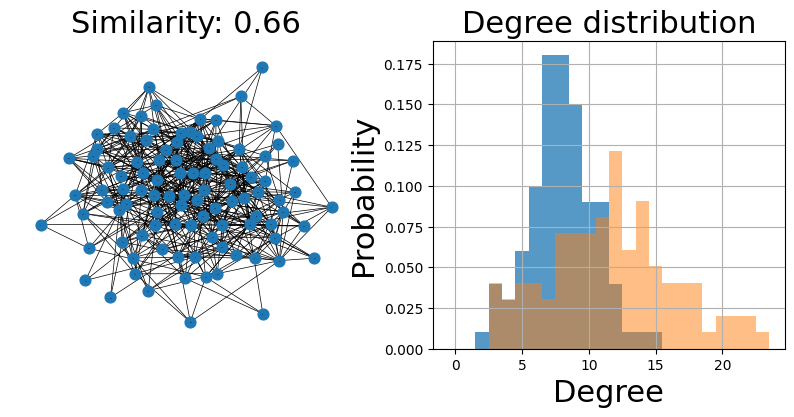

In [98]:
links= int((np.sum(Aw))/0.01)
print(links)

fixMin= 0
fixMax= 25

As= continious_to_sparcity(Aw, links)
graphA = nx.from_numpy_matrix(As)
plotGraph.plot_spring_layout(graphA, None, fixMin, fixMax)

PreAsp= continious_to_sparcity(PreAs[0], links)
graphPreA = nx.from_numpy_matrix(PreAsp)
plotGraph.plot_spring_layout(graphPreA, graphA, fixMin, fixMax, CosSims[0])

PreAsp= continious_to_sparcity(PreAs[1], links)
graphPreA = nx.from_numpy_matrix(PreAsp)
plotGraph.plot_spring_layout(graphPreA, graphA, fixMin, fixMax, CosSims[1])

PreAsp= continious_to_sparcity(PreAs[2], links)
graphPreA = nx.from_numpy_matrix(PreAsp)
plotGraph.plot_spring_layout(graphPreA, graphA, fixMin, fixMax, CosSims[2])

PreAsp= continious_to_sparcity(PreAs[3], links)
graphPreA = nx.from_numpy_matrix(PreAsp)
plotGraph.plot_spring_layout(graphPreA, graphA, fixMin, fixMax, CosSims[3])